# Описание проекта

***Патология*** – это наука, изучающая и диагностирующая различные отклонения от нормы на основе исследования образцов тканей, органов, биологических жидкостей и, в некоторых случаях, даже аутопсий. 

**Цель проекта** – с помощью методов обработки естественного языка и компьютерного зрения создать систему, способную анализировать вопрос к снимку с патологией и генерировать ответ на естественном языке. Данная задача в области машинного обучения называется также задачей Visual Question Answering (VQA) и относится к классу мультимодальных. 

[Данные](https://huggingface.co/datasets/flaviagiammarino/path-vqa) взяты с платформы Hugging Face.

В данном блокноте отражен процесс анализа и отбора данных для обучения.



# Импорты

In [2]:
!pip install datasets

In [3]:
!pip install transformers[torch] datasets -q

In [4]:
!pip install nltk

In [1]:
from datasets import load_dataset
from datasets import DatasetDict
from PIL import Image
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import re

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import base64
from IPython.display import HTML
from IPython.display import display

from sklearn.utils import resample
from collections import Counter

import time
import io
import os

import pickle
import json

2024-08-12 12:42:57.446731: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 12:42:57.446891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 12:42:57.647232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.1.2+cpu


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [83]:
import plotly.io as pio
pio.renderers.default = 'notebook'

Seeds:

In [4]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Данные

In [5]:
# Загрузка датасета
dataset = load_dataset("flaviagiammarino/path-vqa")
dataset.save_to_disk("/kaggle/working/dataset")

Generating train split:   0%|          | 0/19654 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6259 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6719 [00:00<?, ? examples/s]

Saving the dataset (0/8 shards):   0%|          | 0/19654 [00:00<?, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/6259 [00:00<?, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/6719 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 19654
    })
    validation: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6259
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6719
    })
})

Question: is colon present?
Answer: yes


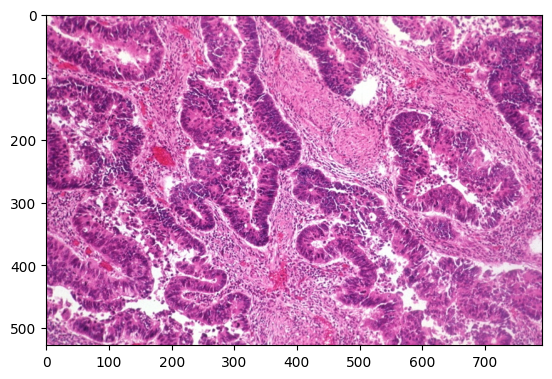

In [7]:
sample = dataset['train'][np.random.randint(0, 100)]

PIL_img = Image.fromarray(np.array(sample['image'])).convert('RGB')
plt.imshow(sample['image'].convert('RGB'))
print("Question: {}".format(sample['question']))
print("Answer: {}".format(sample['answer']))

In [8]:
dataset.keys()

dict_keys(['train', 'validation', 'test'])

Преобразуем датасет в табличную форму для удобства анализа и обработки.

In [9]:
def extract_image_info(df):
    df['image_bytes'] = df['image'].apply(lambda x: x['bytes'])
    df['image_path'] = df['image'].apply(lambda x: x['path'])
    return df

def prepare_df(dataset):
    train_dataset, valid_dataset, test_dataset = dataset['train'], dataset['validation'], dataset['test']
    dataframes = []
    for split in dataset.keys():
        df = extract_image_info(dataset[split].to_pandas())
        df = df.drop(['image'], axis=1)
        dataframes.append(df)
    return dataframes

df_train, df_valid, df_test = prepare_df(dataset)

In [10]:
df_train.head()

question  \
0   where are liver stem cells (oval cells) located?   
1  what are stained here with an immunohistochemi...   
2  what do the areas of white chalky deposits rep...   
3  is embolus derived from a lower-extremity deep...   
4   how is hyperplasia without atypia characterized?   

                                 answer  \
0               in the canals of hering   
1  bile duct cells and canals of hering   
2                  foci of fat necrosis   
3                                   yes   
4     by nests of closely packed glands   

                                         image_bytes    image_path  
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...     img_0.jpg  
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...     img_1.jpg  
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...    img_10.jpg  
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...   img_100.jpg  
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...  img_1000.jpg

# Exploratory Data Analysis

**Проблема:**

Глобально хотим решить задачу VQA в условиях значительной ограниченности ресурсов. 


Один из путей решения -- отбор признаков. Всегда ли есть смысл подавать на вход модели и изображение, и текст вопроса, или можно ограничиться только одним изображением? 

**Решение:**

Проанализируем текстовые признаки, чтобы найти шаблонные вопросы, которые не имеют смысловой значимости. Выделем именованные сущности и исследуем шаблонные вопросы.

**Инструменты:**

Для выделения именованных сущностей использовалась модель [en_core_sci_lg](https://allenai.github.io/scispacy/) из библиотеки scispacy для обработки биомедецинских текстов.

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19654 entries, 0 to 19653
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question     19654 non-null  object
 1   answer       19654 non-null  object
 2   image_bytes  19654 non-null  object
 3   image_path   19654 non-null  object
dtypes: object(4)
memory usage: 614.3+ KB


In [12]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6259 entries, 0 to 6258
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question     6259 non-null   object
 1   answer       6259 non-null   object
 2   image_bytes  6259 non-null   object
 3   image_path   6259 non-null   object
dtypes: object(4)
memory usage: 195.7+ KB


In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6719 entries, 0 to 6718
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question     6719 non-null   object
 1   answer       6719 non-null   object
 2   image_bytes  6719 non-null   object
 3   image_path   6719 non-null   object
dtypes: object(4)
memory usage: 210.1+ KB


In [14]:
def calc_mean(df):
    mean = df[['question', 'image_bytes']].groupby('image_bytes', as_index=False)\
            .agg({'question':'count'}).agg({'question':'mean'})['question']
    return mean

print("Среднее количество вопросов к одному уникальному изображению:")
print("В тренировочном датасете = ", calc_mean(df_train))
print("В валидационном датасете = ", calc_mean(df_valid))
print("В тестовом датасете = ", calc_mean(df_test))

Среднее количество вопросов к одному уникальному изображению:
В тренировочном датасете =  7.562139284340131
В валидационном датасете =  7.522836538461538
В тестовом датасете =  7.831002331002331


Посчитаем среднее количество вопросов к одному изображению:

In [15]:
grouped_df_train = df_train.groupby('image_bytes').agg({
    'question': lambda x: list(x),
    'answer': lambda x: list(x)
}).reset_index()

grouped_df_train.head()

image_bytes  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   

                                            question  \
0  [what shows enlarged ovarian mass on one side ...   
1  [what is required for transcutaneous fnac?, wh...   
2  [what is required for transcutaneous fnac?, wh...   
3  [there is shortening and blunting of the villi...   
4  [what are seen at the margin of ulcer?, where ...   

                                              answer  
0  [specimen of the uterus, one, enlarged ovarian...  
1         [equipments, transcutaneous fnac, yes, no]  
2         [equipments, transcutaneous fnac, yes, no]  
3  [their, shortening and blunting of the villi, ...  
4  [trophozoites of entamoeba histolytica, at the...

На примере одного изображения рассмотрим, какими вопросами оно сопровождается:

In [84]:
import plotly.graph_objects as go
np.random.seed(13)

idx = np.random.randint(0, 100)
img_bytes = grouped_df_train.image_bytes[idx]
questions = grouped_df_train.question[idx]
answers = grouped_df_train.answer[idx]


temp = pd.DataFrame({
    'Question': questions,
    'Answer': answers
})

img = Image.open(io.BytesIO(img_bytes))
img_buffer = io.BytesIO()
img.save(img_buffer, format='PNG')
img_str = base64.b64encode(img_buffer.getvalue()).decode()

# Создание фигуры
fig = go.Figure()

# Добавление изображения
fig.add_layout_image(
    dict(
        source='data:image/png;base64,' + img_str,
        xref="paper",
        yref="paper",
        x=0,
        y=1,
        sizex=0.6,
        sizey=0.6,
        sizing="contain",
        layer="below"
    )
)

# Добавление таблицы
fig.add_trace(
    go.Table(
        header=dict(values=list(temp.columns)),
        cells=dict(values=[temp.Question, temp.Answer]),
        domain=dict(x=[0.5, 1], y=[0, 1])
    )
)

# Настройки осей и размеров
fig.update_xaxes(visible=False, range=[0, 1])
fig.update_yaxes(visible=False, range=[0, 1])

fig.update_layout(
    width=900,
    height=500,
    margin=dict(l=0, r=0, t=0, b=0),
    paper_bgcolor="white",
)

fig.show()

Вопросы заданы таким образом, чтобы с разных сторон описать содержание патологии. 
Видим, что в датасете семантически могут повторяться некоторые пары вопрос-ответ (пример 2 и 3), различаются лишь синтаксические конструкции.

## Типы ответов

Посмотрим, какие типы ответов представлены в датасете.

In [17]:
def determine_answer_type(answer):
  if answer.lower() in ['yes', 'no']:
    return 'yes/no'
  elif answer.lower().isdigit():
    return 'number'
  else:
    return 'other'

df_train['dataset'] = 'train'
df_valid['dataset'] = 'valid'
df_test['dataset'] = 'test'

df_all = pd.concat([df_train, df_valid, df_test]).reset_index(drop=True)
df_all['answer_type'] = df_all['answer'].apply(determine_answer_type)

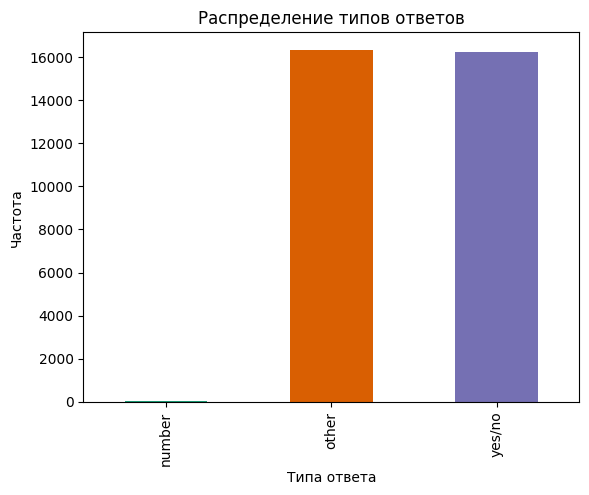

In [18]:
fig, ax = plt.subplots()
df_all.groupby('answer_type').size().plot(kind='bar', color=sns.color_palette('Dark2'), ax=ax)
plt.title('Распределение типов ответов')
ax.set_xlabel('Типа ответа')
ax.set_ylabel('Частота')
plt.show()

In [19]:
df_all.answer_type.value_counts()

answer_type
other     16361
yes/no    16238
number       33
Name: count, dtype: int64

Подавляющее большинство ответов составляют ответы бинарного типа ("да/нет"). Проверим пропорцию в тренировочном, валидационном и тестовом наборах.

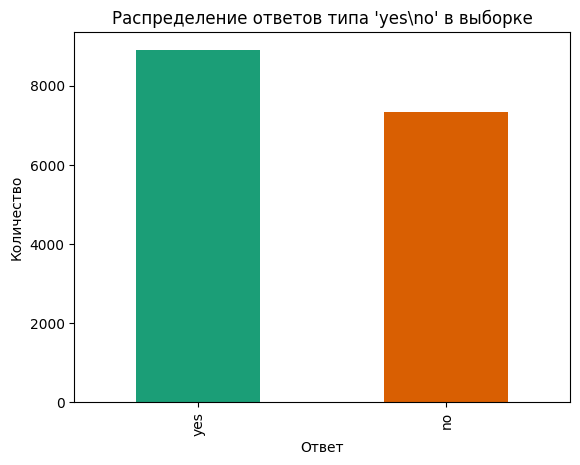

In [20]:
fig, ax = plt.subplots()
df_all[df_all['answer_type']=='yes/no'].answer.value_counts().plot(kind='bar', color=sns.color_palette('Dark2'), ax=ax)
ax.set_title("Распределение ответов типа \'yes\\no\' в выборке")
ax.set_xlabel('Ответ')
ax.set_ylabel('Количество')
plt.show()

In [21]:
df_all[df_all['answer_type']=='yes/no'].answer.value_counts()

answer
yes    8906
no     7332
Name: count, dtype: int64

Видим незначительный дисбаланс. Ответы "да" встречаются чаще.

## Типы вопросов

In [22]:
!pip install spacy==3.7.5
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_lg-0.5.4.tar.gz

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 7.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: spacy
    Found existing installation: spacy 3.7.4
    Uninstalling spacy-3.7.4:
      Successfully uninstalled spacy-3.7.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.2/531.2 MB 1.5 MB/s eta 0:00:0000:0100:05
  Preparing metadata (setup.py) ... done
  Created wheel for en_core_sci_lg: filename=en_core_sci_lg-0.5.4-py3-none-any.whl size=531476532 sha256=35443c4d8c8db7301ebd1904673716cc4316e84d599df37f7b11573cfa954ffc
  Stored in directory: /root/.cache/pip/wheels/04/77/e7/614feae28ed7056dd89b009b32c30573bd85fb7d1ea3c7c227
Successfully built en_core_sci_lg


In [23]:
! pip install scispacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.6.1-py2.py3-none-any.whl.metadata (8.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 40.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 2.7 MB/s eta 0:00:00
Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
  Created wheel for nmslib: filename=nmslib-2.1.1-cp310-cp310-linux_x86_64.whl size=876213 sha256=fb4ef6b54698df8309e350749e2ac5a7b81a0e7a2d25ad986716202c6783157b
  Stored in directory: /root/.cache/pip/wheels/21/1a/5d/4cc754a5b1a88405cad184b76f823897a63a8d19afcd4b9314
Successfully built nmslib
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uni

In [24]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import spacy
import scispacy

exception_words = {'who', 'what', 'where', 'when', 'why', 
                  'do', 'does', 'will', 'have', 'had', 'is', 'are', 'show'}

stop_words_custom = ENGLISH_STOP_WORDS.difference(exception_words)

nlp = spacy.load("en_core_sci_lg")

In [25]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = [word for word in text.split()]
    return ' '.join(words)

def extract_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return entities

def replace_entities_with_x(text, entities):
    for entity in entities:
        text = text.replace(entity, 'X')
    return text

In [26]:
df_que_features = df_all[['question', 'answer', 'dataset']].copy()

In [27]:
df_que_features['preprocessed_question'] = df_que_features['question']\
                                .apply(lambda x: preprocess_text(x))
df_que_features['entities'] = df_que_features['preprocessed_question']\
                                .apply(lambda x: extract_entities(x))
df_que_features['question_template'] = df_que_features\
                                .apply(lambda row: replace_entities_with_x(
                                row['preprocessed_question'], row['entities']),
                                axis=1)

In [28]:
df_que_features.sample(10)

question  \
28691                                   what is present?   
14011  what is infective endocarditis characterized b...   
4855                                  is joints present?   
4308                    is metastatic carcinoma present?   
28965                                where is this from?   
22180                  does this image show cut surface?   
12233  is the covering mucosa grey-white fleshy with ...   
11944  what is there with thickening of their lower p...   
32547                     what are the vascular changes?   
1982                                    what is present?   

                                                  answer dataset  \
28691                                   gastrointestinal    test   
14011                                              large   train   
4855                                                 yes   train   
4308                                                 yes   train   
28965                            gastrointestinal system    test   
22180                                                yes   valid   
12233                                                 no   train   
11944              regular elongation of the rete ridges   train   
32547  hyaline arteriolosclerosis and intimal thicken...    test   
1982                                         hematologic   train   

                                   preprocessed_question  \
28691                                    what is present   
14011  what is infective endocarditis characterized b...   
4855                                   is joints present   
4308                     is metastatic carcinoma present   
28965                                 where is this from   
22180                   does this image show cut surface   
12233  is the covering mucosa greywhite fleshy with a...   
11944  what is there with thickening of their lower p...   
32547                      what are the vascular changes   
1982                                     what is present   

                                                entities  \
28691                                                 []   
14011  [infective endocarditis, characterized, valve ...   
4855                                            [joints]   
4308                              [metastatic carcinoma]   
28965                                                 []   
22180                               [image, cut surface]   
12233            [mucosa, fleshy, haemorrhage, necrosis]   
11944                              [thickening, portion]   
32547                                         [vascular]   
1982                                                  []   

                                       question_template  
28691                                    what is present  
14011  what is X X by that can extend from X onto X X...  
4855                                        is X present  
4308                                        is X present  
28965                                 where is this from  
22180                                 does this X show X  
12233  is the covering X greywhite X with areas of X ...  
11944              what is there with X of their lower X  
32547                             what are the X changes  
1982                                     what is present

In [29]:
df_que_features.question_template.value_counts()[:10]

question_template
what is present              6820
is X present                 5835
what does this X show        3015
where is this                1151
does this X show X           1109
does X show X                 642
does this X show X X          286
is X X present                257
where does this belong to     253
where is this from            247
Name: count, dtype: int64

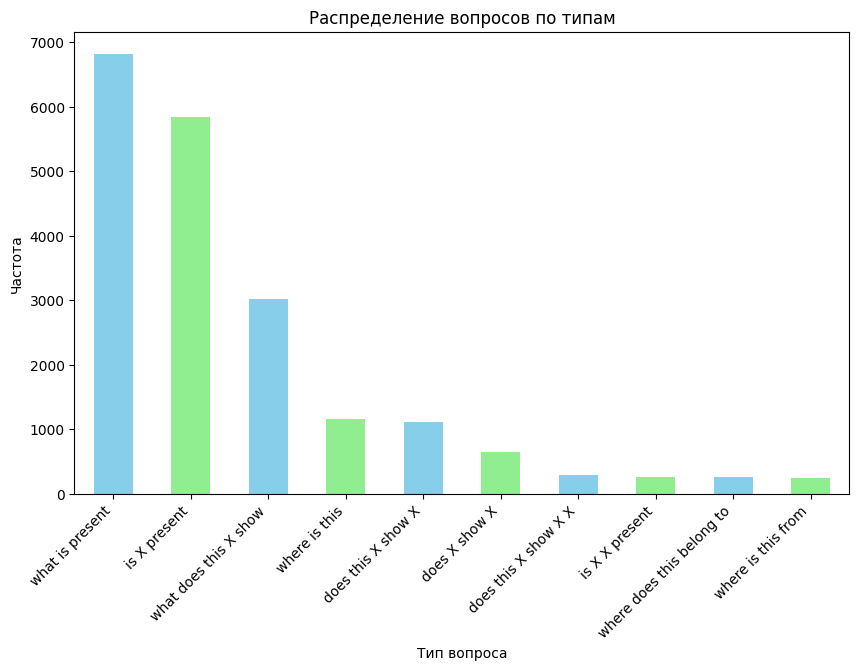

In [30]:
distribution = df_que_features['question_template'].value_counts()[:10]

plt.figure(figsize=(10, 6))
distribution.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Распределение вопросов по типам')
plt.xlabel('Тип вопроса')
plt.ylabel('Частота')
plt.xticks(rotation=45, ha='right')
plt.show()

Значительная часть вопросов в датасете описывается определенными шаблонами. Шаблоны предварительно можно разделить на две группы:

1. Вопросы с бинарным ответом: "is X present", "does this X show X", "does X show X"

2. Вопросы типа: "what is present", "what does this X show", "where is this", "where does this belong to", "where is this from"

Рассмотрим, какие ответы предлагаются к вопросам, описанным данными шаблонами.

### Вопросы с бинарным ответом

In [31]:
bin_templates = ['is X present', 
                 'does this X show X', 
                 'does X show X', 
                 'is X X present',
                 'are X present',
                 'are X X present',
                 'does this X show X X',
                 'does this X show X X X']

df_binary_que = df_que_features[df_que_features['question_template'].isin(bin_templates)]
df_binary_que['answer'].value_counts()

answer
yes            5450
no             2858
extremities       3
dysplastic        1
this              1
Name: count, dtype: int64

Посмотрим на строки, где в качестве ответа выступает 'dysplastic' и 'this':

In [32]:
df_binary_que[df_binary_que['answer'].isin(['dysplastic', 'this', 'extremities'])]

question       answer dataset  \
16634                           are extremities present?  extremities   train   
16637                             is dysplastic present?   dysplastic   train   
20984                           are extremities present?  extremities   valid   
20994  does this image show close-up supernumerary di...         this   valid   
20997                           are extremities present?  extremities   valid   

                                  preprocessed_question  \
16634                           are extremities present   
16637                             is dysplastic present   
20984                           are extremities present   
20994  does this image show closeup supernumerary digit   
20997                           are extremities present   

                                   entities   question_template  
16634                         [extremities]       are X present  
16637                          [dysplastic]        is X present  
20984                         [extremities]       are X present  
20994  [image, closeup supernumerary digit]  does this X show X  
20997                         [extremities]       are X present

Заменим ошибочное значение в исходном датасете:

In [33]:
df_all.iloc[16634, 1] = 'yes'
df_all.iloc[16637, 1] = 'yes'
df_all.iloc[20984, 1] = 'yes'
df_all.iloc[20997, 1] = 'yes'

Посмотрим на частоту встречаемости сущностей:

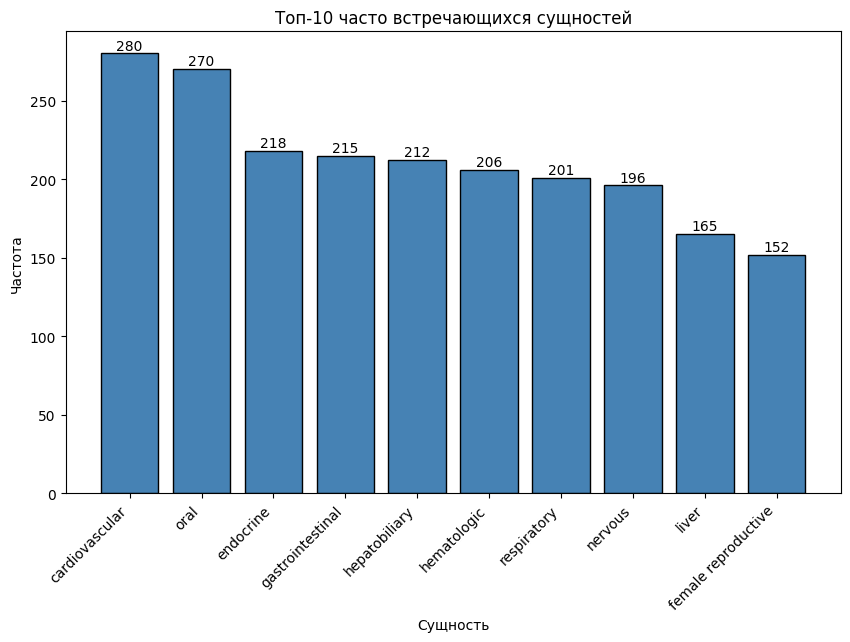

In [34]:
# первая сущность - image, поэтому ее не учитываем
distribution = df_binary_que['entities'].explode().value_counts()[1:11]\
                .reset_index(name='counts')
distribution.columns = ['entity', 'counts']

plt.figure(figsize=(10, 6))
bars = plt.bar(distribution['entity'], distribution['counts'], color='steelblue', edgecolor='black')
plt.title('Топ-10 часто встречающихся сущностей')
plt.xlabel('Сущность')
plt.ylabel('Частота')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, 
             yval + 0.5, 
             round(yval, 1), 
             ha='center', 
             va='bottom')
plt.show()

Сущности представляют собой названия систем органов. Мы можем интерпретировать их как класс, к которому принадлежит объект на изображении.

### Вопросы классифицирующего характера

In [35]:
df_class_que = df_que_features[df_que_features['question_template'].isin(["what is present", 
                                                                          "what does this X show", 
                                                                          "where is this", 
                                                                          "where does this belong to", 
                                                                          "where is this from",
                                                                          "where are X X located",
                                                                          "where is this part in the figure"])]
df_class_que['answer'].value_counts()[:10]

answer
oral                   576
cardiovascular         534
gastrointestinal       416
endocrine              412
hematologic            412
hepatobiliary          380
lung                   340
liver                  297
female reproductive    288
vasculature            284
Name: count, dtype: int64

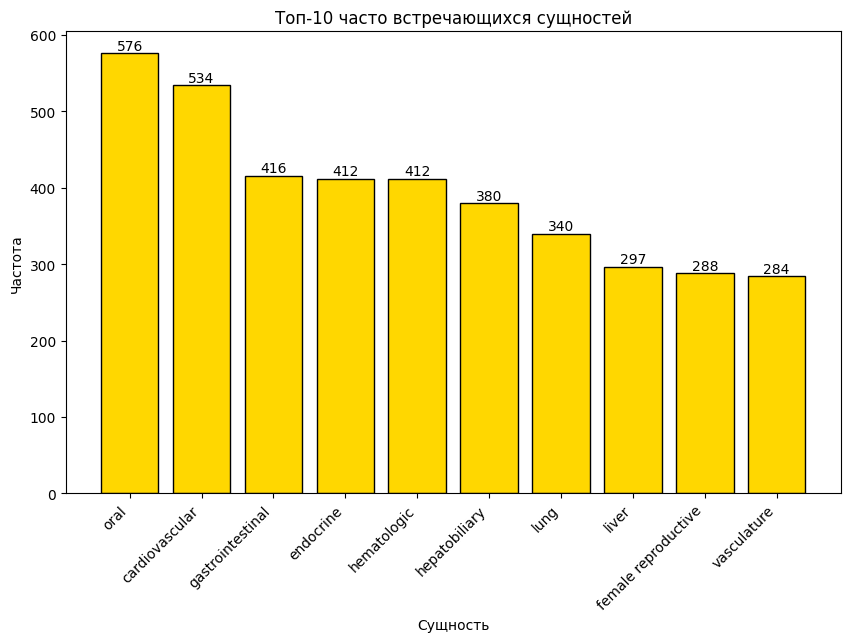

In [36]:
distribution = df_class_que['answer'].value_counts()[:10]\
                .reset_index(name='counts')
distribution.columns = ['entity', 'counts']

plt.figure(figsize=(10, 6))
bars = plt.bar(distribution['entity'], distribution['counts'], color='gold', edgecolor='black')
plt.title('Топ-10 часто встречающихся сущностей')
plt.xlabel('Сущность')
plt.ylabel('Частота')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, 
             yval + 0.5, 
             round(yval, 1), 
             ha='center', 
             va='bottom')
plt.show()

Ответы так же представляют собой названия систем органов, причем по частоте встречаемости получили примерно аналогичный результат. Можем интерпретировать как класс, к которому принадлежить объект на изображении. 

Рассмотрим, пересекаются ли классы:



In [37]:
set(df_class_que['answer'].value_counts()[:10].index)

{'cardiovascular',
 'endocrine',
 'female reproductive',
 'gastrointestinal',
 'hematologic',
 'hepatobiliary',
 'liver',
 'lung',
 'oral',
 'vasculature'}

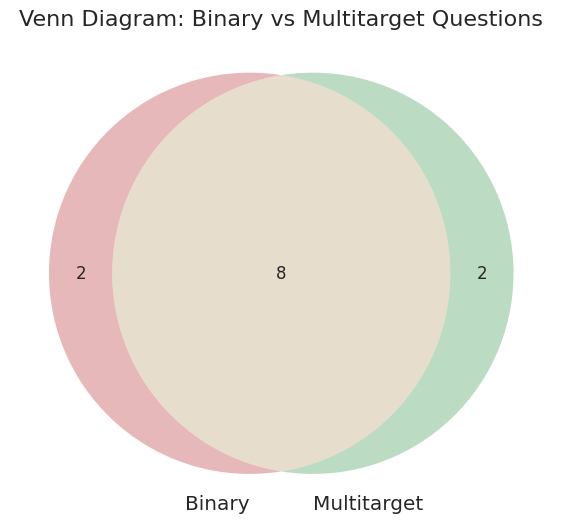

In [38]:
from matplotlib_venn import venn2
sns.set(style="whitegrid")

set_binary = set(df_binary_que['entities'].explode().value_counts()[1:11].index)
set_multitarget = set(df_class_que['answer'].value_counts()[:10].index)

plt.figure(figsize=(7, 7))
venn = venn2([set_binary, set_multitarget], ('Binary', 'Multitarget'))

plt.title("Venn Diagram: Binary vs Multitarget Questions", fontsize=16)
plt.show()

Видим, что самые часто упоминаемые классы пересекаются. То есть для одного класса вопрос в датасете может быть задан несколькими формулировками.

### Нешаблонные вопросы

Рассмотрим случай, когда вопрос не подходит ни под один часто употребимый шаблон.

In [39]:
index_bin, index_mult = df_binary_que.index, df_class_que.index
index_exclude = index_bin.append(index_mult)

df_open_que = df_que_features.iloc[~df_que_features.index.isin(index_exclude)]
df_open_que.head()

question  \
1   what are stained here with an immunohistochemi...   
2   what do the areas of white chalky deposits rep...   
3   is embolus derived from a lower-extremity deep...   
4    how is hyperplasia without atypia characterized?   
11  does this image show excellent photo typical a...   

                                  answer dataset  \
1   bile duct cells and canals of hering   train   
2                   foci of fat necrosis   train   
3                                    yes   train   
4      by nests of closely packed glands   train   
11                                   yes   train   

                                preprocessed_question  \
1   what are stained here with an immunohistochemi...   
2   what do the areas of white chalky deposits rep...   
3   is embolus derived from a lowerextremity deep ...   
4     how is hyperplasia without atypia characterized   
11  does this image show excellent photo typical a...   

                                             entities  \
1   [stained, immunohistochemical stain, cytokeratin]   
2                            [white chalky, deposits]   
3   [embolus, lowerextremity, deep venous thrombus...   
4                [hyperplasia, atypia, characterized]   
11  [image, excellent, photo, adenocarcinoma, musc...   

                                    question_template  
1                     what are X here with an X for X  
2                  what do the areas of X X represent  
3                    is X derived from a X X X in a X  
4                                how is X without X X  
11  does this X show X X typical X extending throu...

In [41]:
df_open_que['question_template'].value_counts()[:10]

question_template
what are present            178
does X show X X             161
where is this X in the X    104
where is this part in        99
what X                       88
how does this X show X       76
is X in X present            75
does X X show X              62
what is X                    61
is X                         61
Name: count, dtype: int64

In [42]:
df_open_que['question_length'] = df_open_que['question'].apply(lambda x: len(x.split()))
df_open_que['answer_length'] = df_open_que['answer'].apply(lambda x: len(x.split()))

/tmp/ipykernel_33/1305757680.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_33/1305757680.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



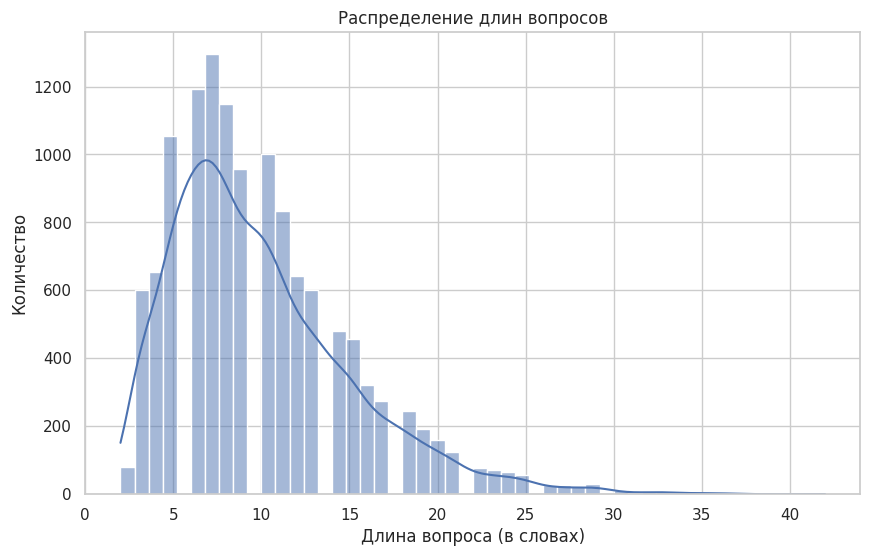

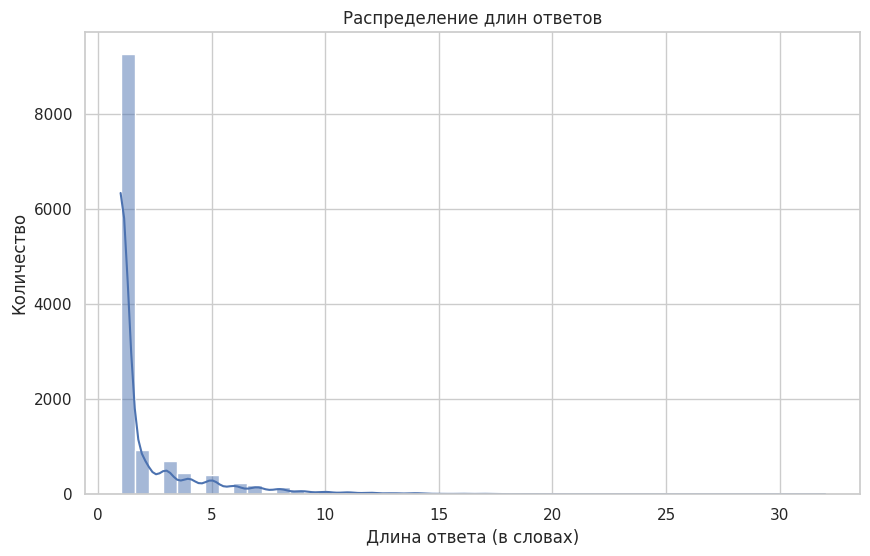

In [43]:
plt.figure(figsize=(10, 6))
sns.histplot(df_open_que['question_length'], bins=50, kde=True)
plt.title('Распределение длин вопросов')
plt.xlabel('Длина вопроса (в словах)')
plt.ylabel('Количество')
plt.show();

plt.figure(figsize=(10, 6))
sns.histplot(df_open_que['answer_length'], bins=50, kde=True)
plt.title('Распределение длин ответов')
plt.xlabel('Длина ответа (в словах)')
plt.ylabel('Количество')
plt.show()

Большая часть вопросов, не описываемая единым шаблоном, также требует бинарного ответа (судя по длине ответа в словах, унимодальное, скошенное вправо распределение)

**Вывод:**

Шаблонные вопросы можем в некоторых случаях не учитывать как признак, а в качестве таргета (класса принадлежности объекта на изображении) примем название сущности.

Таким образом, поставленная задача разделяется на три подзадачи:

1. **Задача бинарной классификации** (да/нет вопросы) --> архитектура - мультимодальная нейронная сеть

*Вход*: изображение + вопрос (текстовая последовательность)

*Выход*: класс (0, 1)

2. **Задача многоклассовой классификации** (вопросы с рассмотренными шаблонами, класс = название сущности) --> архитектура - CNN

*Вход*: изображение

*Выход*: класс

3. **Задача генерации текста** (в случае, когда вопрос не описывается конкретным шаблоном) --> архитектура - мультимодальная генеративная нейросеть

*Вход*: изображение + вопрос + ответ

*Выход*: текстовая последовательность

# Подготовка данных

## Binary classification

Отберем данные по колонке 'answer'

In [44]:
binary_train = df_train[df_train['answer'].isin(['yes', 'no'])]
binary_valid = df_valid[df_valid['answer'].isin(['yes', 'no'])]
binary_test= df_test[df_test['answer'].isin(['yes', 'no'])]

print(f"Train shape = {binary_train.shape}")
print(f"Valid shape = {binary_valid.shape}")
print(f"Test shape = {binary_test.shape}")

Train shape = (9751, 5)
Valid shape = (3125, 5)
Test shape = (3362, 5)


Текущее соотношение тренировочных, валидационных и тестовых данных 60:19:21

Разделим данные в соотношении 70:15:15

In [45]:
from sklearn.model_selection import train_test_split

binary_all = pd.concat([binary_train, binary_valid, binary_test])

train_data_bin, temp_data = train_test_split(binary_all, test_size=0.3, random_state=42)
valid_data_bin, test_data_bin = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Train shape = {train_data_bin.shape}")
print(f"Valid shape = {valid_data_bin.shape}")
print(f"Test shape = {test_data_bin.shape}")

Train shape = (11366, 5)
Valid shape = (2436, 5)
Test shape = (2436, 5)


In [46]:
train_data_bin[['question', 'answer', 'image_path']].to_csv('binary_train.csv')
valid_data_bin[['question', 'answer', 'image_path']].to_csv('binary_valid.csv')
test_data_bin[['question', 'answer', 'image_path']].to_csv('binary_test.csv')

## Multitarget classification

В подвыборку для решения задачи многоклассовой классификации включим изображения, сопровождающиеся классифицирующими вопросами,а также вопросами бинарного типа с положительным ответом.

***Ex: is cardiovasular present? --> yes => class = cardiovascular***

In [47]:
df_binary_que.head(10)

question answer dataset  \
5                   is normal palmar creases present?     no   train   
14                       is gastrointestinal present?    yes   train   
16               is mucoepidermoid carcinoma present?     no   train   
18                                  is colon present?    yes   train   
19                                  is edema present?     no   train   
28                       is gastrointestinal present?    yes   train   
29                                is adrenal present?     no   train   
31                                  is colon present?    yes   train   
41                       is gastrointestinal present?    yes   train   
42  is alpha smooth muscle actin immunohistochemic...     no   train   

                                preprocessed_question  \
5                    is normal palmar creases present   
14                        is gastrointestinal present   
16                is mucoepidermoid carcinoma present   
18                                   is colon present   
19                                   is edema present   
28                        is gastrointestinal present   
29                                 is adrenal present   
31                                   is colon present   
41                        is gastrointestinal present   
42  is alpha smooth muscle actin immunohistochemic...   

                                            entities question_template  
5                           [normal, palmar creases]    is X X present  
14                                [gastrointestinal]      is X present  
16                        [mucoepidermoid carcinoma]      is X present  
18                                           [colon]      is X present  
19                                           [edema]      is X present  
28                                [gastrointestinal]      is X present  
29                                         [adrenal]      is X present  
31                                           [colon]      is X present  
41                                [gastrointestinal]      is X present  
42  [alpha smooth muscle actin, immunohistochemical]    is X X present

In [48]:
train_idx = df_class_que[df_class_que['dataset'] == 'train'].index.tolist()
valid_idx = df_class_que[df_class_que['dataset'] == 'valid'].index.tolist()
test_idx = df_class_que[df_class_que['dataset'] == 'test'].index.tolist()

subset_train_mult = df_train[df_train.index.isin(train_idx)][['answer', 'image_path']].rename(columns={'answer':'target'})
subset_valid_mult = df_valid[df_valid.index.isin(valid_idx)][['answer', 'image_path']].rename(columns={'answer':'target'})
subset_test_mult = df_test[df_test.index.isin(test_idx)][['answer', 'image_path']].rename(columns={'answer':'target'})

In [49]:
train_idx_bin = df_binary_que[(df_binary_que['dataset'] == 'train') & (df_binary_que['answer'] == 'yes')].index.tolist()
valid_idx_bin = df_binary_que[(df_binary_que['dataset'] == 'valid') & (df_binary_que['answer'] == 'yes')].index.tolist()
test_idx_bin = df_binary_que[(df_binary_que['dataset'] == 'test') & (df_binary_que['answer'] == 'yes')].index.tolist()

subset_train_bin = df_all[df_all.index.isin(train_idx_bin)].copy()
subset_valid_bin = df_all[df_all.index.isin(valid_idx_bin)].copy()
subset_test_bin = df_all[df_all.index.isin(test_idx_bin)].copy()

subset_train_bin['entities'] = df_binary_que.loc[subset_train_bin.index, 'entities']
subset_valid_bin['entities'] = df_binary_que.loc[subset_valid_bin.index, 'entities']
subset_test_bin['entities'] = df_binary_que.loc[subset_test_bin.index, 'entities']

subset_train_bin['target'] = subset_train_bin['entities'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
subset_valid_bin['target'] = subset_valid_bin['entities'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
subset_test_bin['target'] = subset_test_bin['entities'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

subset_train_bin = subset_train_bin[['image_path', 'target']]
subset_valid_bin = subset_valid_bin[['image_path', 'target']]
subset_test_bin = subset_test_bin[['image_path', 'target']]

In [50]:
multitarget_train = pd.concat([subset_train_mult, subset_train_bin])
multitarget_valid = pd.concat([subset_valid_mult, subset_valid_bin])
multitarget_test = pd.concat([subset_test_mult, subset_test_bin])

print(f"Train shape = {multitarget_train.shape}")
print(f"Valid shape = {multitarget_valid.shape}")
print(f"Test shape = {multitarget_test.shape}")

Train shape = (10219, 2)
Valid shape = (1083, 2)
Test shape = (1108, 2)


In [51]:
multitarget_all = pd.concat([multitarget_train, multitarget_valid, multitarget_test])

Для задачи многоклассовой классификации отберем только те классы, в которых представлено не менее 100 объектов.

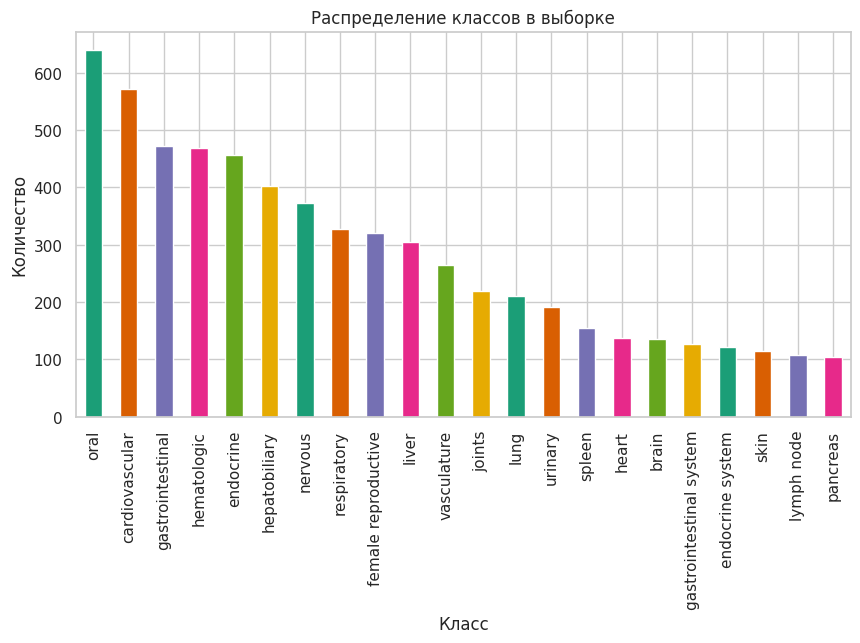

In [52]:
fig, ax = plt.subplots(figsize=(10,5))

class_freq = multitarget_all['target'].value_counts()
filtered_class = class_freq[class_freq >= 100]
filtered_class.plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'), ax=ax)
ax.set_title("Распределение классов в выборке")
ax.set_xlabel('Класс')
ax.set_ylabel('Количество')

plt.show()

In [53]:
classes = filtered_class.index.tolist()
print('Список классов: ', classes)
print('\nКоличество классов (с более 100 объектов): ', len(classes))

Список классов:  ['oral', 'cardiovascular', 'gastrointestinal', 'hematologic', 'endocrine', 'hepatobiliary', 'nervous', 'respiratory', 'female reproductive', 'liver', 'vasculature', 'joints', 'lung', 'urinary', 'spleen', 'heart', 'brain', 'gastrointestinal system', 'endocrine system', 'skin', 'lymph node', 'pancreas']

Количество классов (с более 100 объектов):  22


Получили всего 22 класса. Отберем набор данных для обучения в пропорции 70:15:15

In [54]:
multitarget_all = multitarget_all[multitarget_all['target'].isin(classes)].sample(frac=1, random_state=13).reset_index(drop=True)

train_data_mult, temp_data = train_test_split(multitarget_all, test_size=0.3, random_state=42, stratify=multitarget_all['target'])
valid_data_mult, test_data_mult = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['target'])

print(f"Train shape = {train_data_mult.shape}")
print(f"Valid shape = {valid_data_mult.shape}")
print(f"Test shape = {test_data_mult.shape}")

Train shape = (4358, 2)
Valid shape = (934, 2)
Test shape = (935, 2)


In [55]:
train_data_mult.to_csv('multitarget_train.csv')
valid_data_mult.to_csv('multitarget_valid.csv')
test_data_mult.to_csv('multitarget_test.csv')

## Generation task

In [80]:
train_data_gen = df_train[~df_train['answer'].isin(['yes', 'no'])][['question', 'answer', 'image_path']]
valid_data_gen = df_valid[~df_valid['answer'].isin(['yes', 'no'])][['question', 'answer', 'image_path']]
test_data_get = df_test[~df_test['answer'].isin(['yes', 'no'])][['question', 'answer', 'image_path']]

In [82]:
train_data_gen.to_csv('generation_train.csv')
valid_data_gen.to_csv('generation_valid.csv')
test_data_get.to_csv('generation_test.csv')